In [1]:
%matplotlib widget

In [2]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.spatial.distance import euclidean
from scipy.stats import mannwhitneyu
from scipy.interpolate import interp1d
from pathlib import Path
import flammkuchen as fl
from bouter.utilities import fast_pearson,fast_corrcoef
from tqdm import tqdm
from scipy.ndimage import zoom, gaussian_filter
from scipy.signal import medfilt, convolve
from scipy import ndimage
import flammkuchen as fl
import tifffile
from bouter.embedded import EmbeddedExperiment
import seaborn as sns
from scipy.stats import sem
from scipy.stats import zscore
import json
import imageio
from sklearn.cluster import KMeans as km
from scipy.signal import medfilt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from scipy.ndimage import gaussian_filter as gf
from scipy.signal import convolve
from numba import jit
from scipy.signal import detrend
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter as sgf
from sklearn.cluster import KMeans, SpectralClustering,DBSCAN,AffinityPropagation,OPTICS,AgglomerativeClustering
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
import scipy.cluster.hierarchy as spc
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
from split_dataset import SplitDataset

In [3]:
def compute_temporal_distance(array_):
    where_crop = np.array([[605, 690], [745, 830]])
    ttas_norm = np.zeros(array_.shape)
    coords_out = np.zeros((array_.shape[0],2))
    for i in range(array_.shape[0]):
        norm_array = remove_baseline(array_[i,:])
        ttas_norm[i,:] = norm_array
        coords_out[i,:] = np.array([norm_array[where_crop[0,0]:where_crop[0,1]].mean(),
                                   norm_array[where_crop[1,0]:where_crop[1,1]].mean()])
    return ttas_norm,coords_out

def remove_baseline(x_):
    return (x_ - np.nanmedian(x_[440:490]))/np.std(x_)

@jit(nopython=True)
def similarity_coords(list_coords,extra,th=.6, n_min=4, additional=None):
    coords_out = []
    extra_out = []
    len_ = len(list_coords)
    for n_up in range(len_):
        coords = list_coords[n_up].copy()
        extra0 = extra[n_up].copy()
        if coords.shape[0]>0:
            for n_neuron in range(coords.shape[0]):
                coord = coords[n_neuron,:]
                extra1 = extra0[n_neuron]
                animal_found = 0
                #look into the other brains
                for n_down in range(len_):
                    animal = list_coords[n_down].copy()
                    if (animal.shape[0]>0) and (n_up!=n_down):
                        for n_other_neurons in range(animal.shape[0]):
                            other_coord = animal[n_other_neurons,:]
                            animal_distance = fast_pearson(other_coord,coord)
                            if animal_distance >= th:
                                animal_found += 1 
                                break
                if animal_found>=n_min:
                    coords_out.append(coord)
                    extra_out.append(extra1)
    return coords_out,extra_out

def color_density(coordinates,th=30):
    tot_cells = coordinates.shape[0]
    values = np.zeros(tot_cells)
    for n_cell in range(tot_cells):
        counter = 0
        for n_cell_down in range(tot_cells):
            if n_cell !=n_cell_down:
                if euclidean(coordinates[n_cell,:],coordinates[n_cell_down,:]) <=th:
                    counter += 1
        values[n_cell] = counter #/ tot_cells
    return values 

@jit
def in_cluster(clusters_):
    n_ = clusters_.shape[1]
    out_ = np.zeros((n_,n_))
    for i_row in range(n_):
        vect0 = clusters_[:,i_row]
        for i_col in range(n_):
            vect1 = clusters_[:,i_col]
            out_[i_row,i_col] = np.sum(vect0==vect1)
    return out_

def create_bin_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return 1*(distance <= r)

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 
    
def double_exp(x, tau0,tau1):
    out = +(+np.exp(-tau1 * x))-(+np.exp(-tau0 * x))
    return (out)

In [4]:
plt.rcParams.update({'font.size': 25})

In [5]:
reg = fl.load(r"C:\Users\ge59xan\Desktop\epaoli\ValenceProject\salt_calibrated_stimulus.h5")["experiment_trace"]
f = interp1d(np.arange(2400), np.concatenate([reg,[0]]))
res_reg = f(np.arange(0, (4800/2)-.5, 0.5))
res_reg = np.concatenate([res_reg,[0]])

reg_temp = fl.load(r"C:\Users\ge59xan\Desktop\epaoli\ValenceProject\temperature_calibrated_stimulus.h5")["long_experiment_trace"]
f = interp1d(np.arange(2400), np.concatenate([reg_temp,[0]]))
res_reg_temp = f(np.arange(0, (4800/2)-.5, 0.5))
res_reg_temp = np.concatenate([res_reg_temp,[0]])

In [6]:
list_files = [Path(r"U:\experiments\virtual_gradients_experiments\Batch_1\210504_f0"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_1\210504_f1"), #H2b
             Path(r"U:\experiments\virtual_gradients_experiments\Batch_2\210514_f0"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_2\210514_f1"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_4\210607_f0")]#H2b 

In [7]:
list_regions = ["rHb","lHb","IPN","DRN","MRN","lLOB","lROB","OT","vSp",
                "mOB","lOE","rOE","dSp","Pa","dTh","PT","PO","Cb","dHind",
               "vHind","Tor"]

In [8]:
x_proj = imageio.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\x_proj_png.png")[:,:,0]
y_proj = imageio.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\y_proj_png.png")[:,:,0]
z_proj = imageio.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\z_proj_png.png")[:,:,0]

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as i

In [9]:
AO = tifffile.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\AO.tif")
regions_ids = fl.load(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\regions_mask.h5")["array"]
sf_AO = zoom(tifffile.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\210504_f1_affine_AO.tif"),(9.6,0.6,0.6))

In [10]:
array = np.stack([medfilt(np.diff(res_reg[960:960*2]),1)]*959)

In [42]:
wcxt_r = np.zeros(res_reg.shape)
icxt_r = np.zeros(res_reg.shape)
wcxt_r[1:][medfilt(np.diff(res_reg),41)>0.0] = 1
icxt_r[1:][medfilt(np.diff(res_reg),41)<0.0] = 1

In [44]:
fl.save(r"C:\Users\ge59xan\Desktop\context_regressors.h5",np.stack([wcxt_r, icxt_r]))

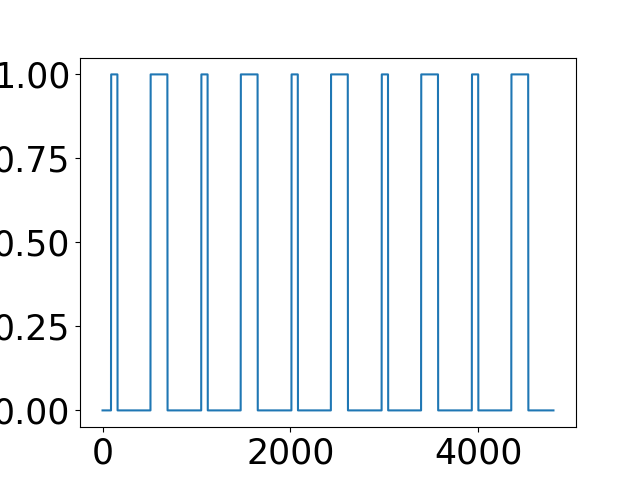

In [43]:
plt.figure()
plt.plot(wcxt_r)
# plt.plot(icxt_r)
plt.show()

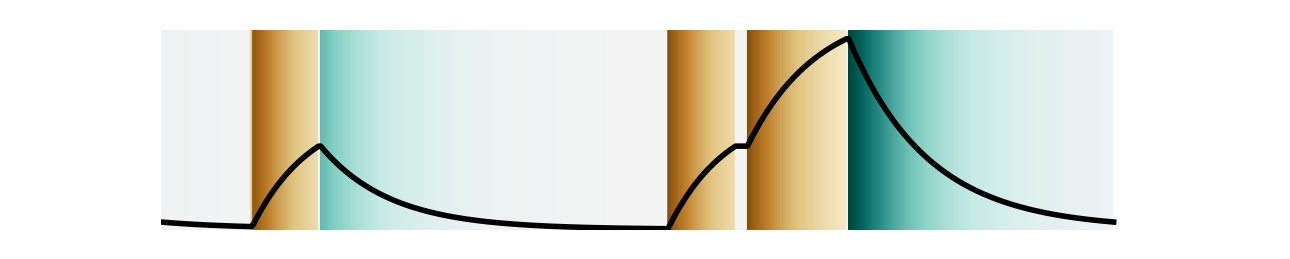

In [59]:
alpha_ = 1
plt.figure()
plt.imshow(array,aspect="auto",cmap="BrBG_r",alpha=1, vmin=-0.03,vmax=0.03)
plt.plot(res_reg[960:960*2],"k", lw=4)

plt.ylim([-0.02,2.4])
plt.yticks([])
plt.xticks([])
sns.despine(left=True,bottom=True)
set_size(10,2)
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\3_c.png",dpi=800)

In [11]:
sensory_neurons = []
the_rest = []
exampes = []
pooled_traces = []
pooled_coords = []
rel_th = .3
name_session = "temp"
fish_id = []
id_ = 1

n_rois = []

for fish_path in tqdm(list_files):
    data_integration = fl.load(fish_path / "imaging" /name_session/ "behavioural_model_fitting_v02.h5")
    n_rois.append(data_integration["fitting"][:,0].shape[0])
##implicitly, np.isfinite(data_integration["fitting"][:,0]) is a thresholding on rel index of 0.3. To change to a more comprehensible form
    rois_integration = np.isfinite(data_integration["fitting"][:,0])&(data_integration["coordinates"][:,-1]!=0)&(data_integration["coordinates"][:,-1]!=11)&(data_integration["coordinates"][:,-1]!=12)
    a,b = compute_temporal_distance(data_integration["ttas"][rois_integration,:])
    pooled_traces.append(zscore(a,1))
    pooled_coords.append(data_integration["coordinates"][rois_integration,:-1])
    
    traces = fl.load(fish_path / "imaging" /"temp"/ "traces.h5")["traces"]
    exp = EmbeddedExperiment(fish_path / "behavior" /"temp")
    bouts = exp.get_bout_properties()
    motor_regressor = np.zeros(traces.shape[1])
    for n_bout in range(len(bouts)):
        bout_idx = int(bouts["t_start"][n_bout].copy() *2)
        motor_regressor[bout_idx] = 1
    kernel = double_exp(np.linspace(0,20,40), .8,.3)
    motor_regressor = zscore(convolve(motor_regressor,kernel,mode="full")[:-39])
    rois_integration = np.isfinite(data_integration["fitting"][:,0])&(data_integration["coordinates"][:,-1]!=0)&(data_integration["coordinates"][:,-1]!=11)&(data_integration["coordinates"][:,-1]!=12)
    motor_corr = np.zeros(traces.shape[0])
    for i in tqdm(range(traces.shape[0])):
        corr = fast_pearson(traces[i,:],motor_regressor)
        motor_corr[i] = corr
    sensory_neurons.append(motor_corr[np.isfinite(motor_corr)][rois_integration])
    the_rest.append(motor_corr[np.isfinite(motor_corr)][motor_corr[np.isfinite(motor_corr)]>=np.percentile(motor_corr[np.isfinite(motor_corr)],90)])
    exampes.append([traces[np.nanargmax(motor_corr)], motor_regressor, exp.behavior_log.t, exp.behavior_log.tail_sum])

100%|█████████████████████████████████████████████████████████████████████████| 77981/77981 [00:01<00:00, 41909.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.02s/it]


In [ ]:
_ ,full_coords = similarity_coords(pooled_traces,sensory_neurons,th=.6)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extra' of function 'similarity_coords'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_13612\4176090208.py", line 15:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'list_coords' of function 'similarity_coords'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-t

In [18]:
mannwhitneyu(np.array(full_coords), np.concatenate(the_rest))

MannwhitneyuResult(statistic=10553791.5, pvalue=0.0)

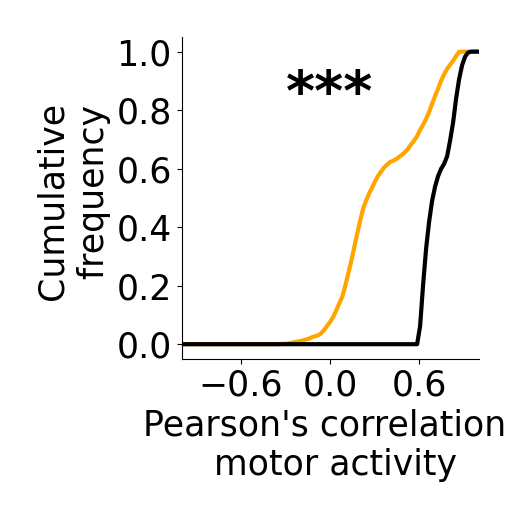

In [26]:
bins_ = np.linspace(-1,1,100)

bins_plot = (bins_[1:]+bins_[:-1]) / 2
plt.figure()

c,_ = np.histogram(full_coords,bins_)
c = np.cumsum(c / np.sum(c))

plt.plot(bins_plot, c, c="orange", lw=3)

c,_ = np.histogram(np.concatenate(the_rest),bins_)
c = np.cumsum(c / np.sum(c))

plt.plot(bins_plot, c, c="k", lw=3)
plt.text(-.3,.8,"***",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Cumulative \n frequency", fontsize=25)
plt.xlabel("Pearson's correlation \n motor activity", fontsize=25)
plt.yticks([0,.2,.4,.6,.8,1], fontsize=25)
plt.xticks([-.6,0,.6], fontsize=25)
plt.xlim(-1,1)
set_size(4,4)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point3_0.png",dpi=800)

In [31]:
def

(4800,)

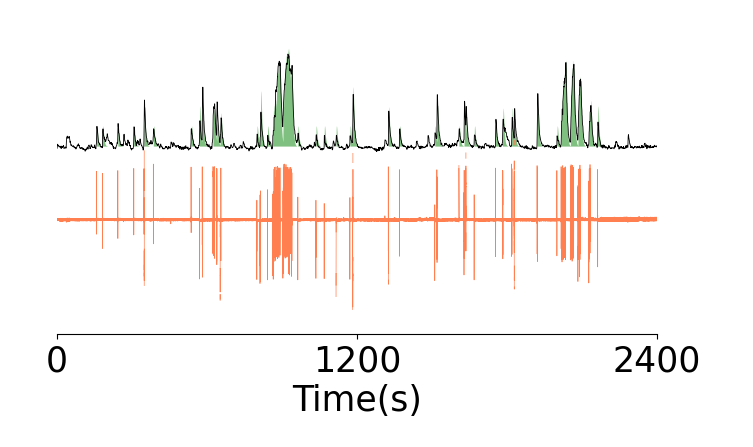

In [66]:
i_fish = 2
time_imaging = np.linspace(0,2400,4800)
plt.figure()
plt.plot(time_imaging, zscore(medfilt(exampes[i_fish][0],5)), "k", lw=.6)
plt.fill_between(time_imaging, np.ones(4800)*np.nanmin(exampes[i_fish][1]),
                 exampes[i_fish][1], color="green", lw=0,alpha=.5)
z_tail = (exampes[i_fish][3] - np.nanmean(exampes[i_fish][3]))/np.nanstd(exampes[i_fish][3])
plt.plot(exampes[i_fish][2],(z_tail/5)-5,c="coral",lw=.5)
plt.yticks([])
plt.xticks([0,1200,2400])
plt.xlim([0,2400])
plt.xlabel("Time(s)")
sns.despine(left=True)
plt.tight_layout()
set_size(6,3)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev1_point3_1.png",dpi=800)

In [12]:
full_,full_coords = similarity_coords(pooled_traces,pooled_coords,th=.6)
full_ = np.stack(full_,0)
full_coords = np.stack(full_coords,0)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'extra' of function 'similarity_coords'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_9512\4176090208.py", line 15:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'list_coords' of function 'similarity_coords'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-ty

In [13]:
def bin_(x_,n=300):
    out_ = np.zeros((n,x_.shape[1]))
    bins = np.linspace(0,960,n).astype(int)
    for n_, (s_,e_) in enumerate(zip(bins[:-1],bins[1:])):
        out_[n_,:] = np.nanmean(x_[s_:e_,:],0)
    return out_

In [14]:
full_.T.shape

(960, 3272)

In [15]:
model_tpca = PCA(2).fit(full_.T)
points_tpca = model_tpca.transform(full_.T)

In [16]:
intervals = [[111,192,392],[526,670,895]]

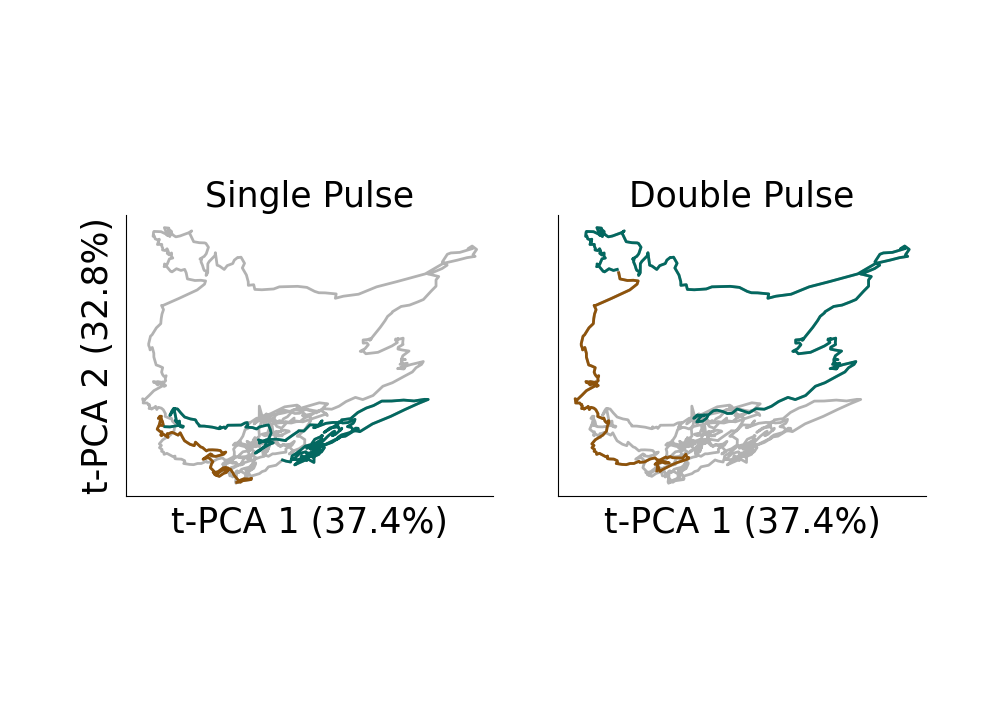

In [21]:
f,a = plt.subplots(1,2)
a[0].plot(points_tpca[:,0],points_tpca[:,1], lw=2, c="gray", alpha=.6)

a[0].plot(points_tpca[intervals[0][0]:intervals[0][1],0],
            points_tpca[intervals[0][0]:intervals[0][1],1],
            "-",lw=2,c="#8e530b")
a[0].plot(points_tpca[intervals[0][1]:intervals[0][2],0],
            points_tpca[intervals[0][1]:intervals[0][2],1],
            "-",lw=2,c="#036860")


a[0].set_xlabel("t-PCA 1 (37.4%)", fontsize=25)
a[0].set_ylabel("t-PCA 2 (32.8%)", fontsize=25)
a[0].set_aspect(1)
a[0].set_yticks([])
a[0].set_xticks([])
a[0].set_title("Single Pulse", fontsize=25)


a[1].plot(points_tpca[:,0],points_tpca[:,1], lw=2, c="gray", alpha=.6)

a[1].plot(points_tpca[intervals[1][0]:intervals[1][1],0],
            points_tpca[intervals[1][0]:intervals[1][1],1],"-",
            lw=2,c="#8e530b")
a[1].plot(points_tpca[intervals[1][1]:intervals[1][2],0],
            points_tpca[intervals[1][1]:intervals[1][2],1],"-",
            lw=2,c="#036860")
a[1].set_xlabel("t-PCA 1 (37.4%)", fontsize=25)
a[1].set_yticks([])
a[1].set_xticks([])
a[1].set_aspect(1)
a[1].set_title("Double Pulse", fontsize=25)

sns.despine()
plt.tight_layout()
set_size(8,6)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\panels_afterreview\3_f_newnew.png",dpi=800)

In [25]:
model_pca = PCA(20).fit(full_)
points_pca = model_pca.transform(full_)[:,:2]

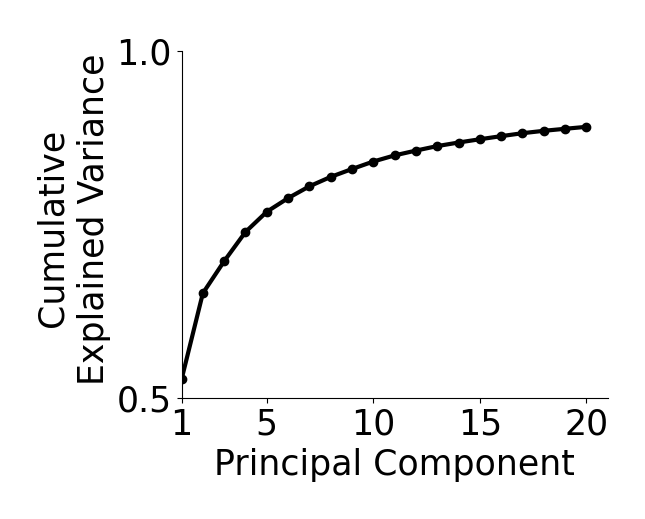

In [21]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(1,21),np.cumsum(model_pca.explained_variance_ratio_),"-ok",lw=3,alpha=1)
plt.ylabel("Cumulative \n Explained Variance",fontsize=25)
plt.xlabel("Principal Component",fontsize=25)
plt.xlim([1,21])
plt.xticks(np.linspace(1,20,5).astype(int), fontsize=25)
plt.ylim([0.5,1])
plt.yticks([.5,1],fontsize=25)
sns.despine()
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_4_a.png",dpi=800)

In [22]:
max_clusters = 20
sil_score_full = []
for n_shuffle in range(30):
    sil_score = []
    for n_ in np.arange(2,max_clusters):
        np.random.seed(n_shuffle)
        clusters_model = KMeans(n_,random_state=None).fit(points_pca)
        score = davies_bouldin_score(points_pca, clusters_model.labels_,
                                     )
        sil_score.append(score)
    sil_score_full.append(np.array(sil_score))

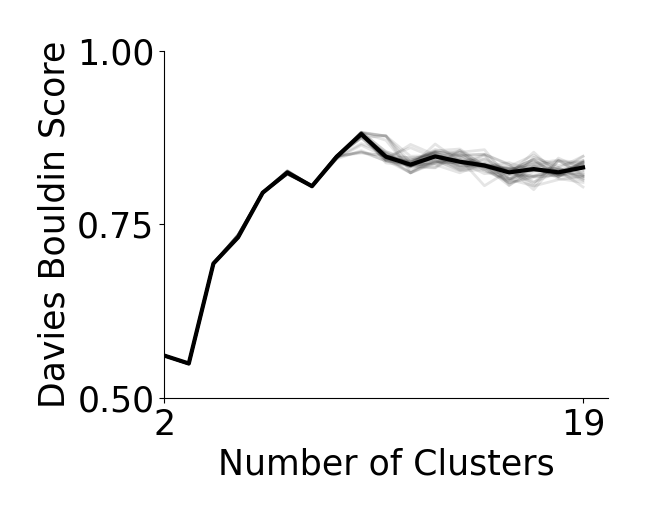

In [23]:
plt.figure(figsize=(7,5))
for to_plot in sil_score_full:
    plt.plot(np.arange(2,max_clusters),to_plot,"-k",lw=2,alpha=.1)
plt.plot(np.arange(2,max_clusters),np.nanmedian(np.stack(sil_score_full,0),0),"-k",lw=3,alpha=1)
plt.ylabel("Davies Bouldin Score",fontsize=25)
plt.xlabel("Number of Clusters",fontsize=25)
plt.xlim([2,max_clusters])
plt.xticks([2,max_clusters-1],fontsize=25)
plt.yticks([0.5,.75,1],fontsize=25)
sns.despine()
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_4_b.png",dpi=800)

In [24]:
cluster_model = KMeans(3,random_state=None).fit(points_pca)
cluster_labels = cluster_model.predict(points_pca)

NameError: name 'points_pca' is not defined

In [31]:
color_list = ["#cb6a49",
"#a46cb7",
"#7aa457"]
colors = ListedColormap(color_list)

In [ ]:
n_iters = 500
cluster_assignment = np.zeros((n_iters,points_pca.shape[0]))
for n_iter in range(n_iters):
#     np.random.seed(n_iter)
    np.random.seed(np.random.randint(500))
    cluster_assignment_iter = KMeans(3,random_state=np.random.randint(500)).fit_predict(points_pca)
    cluster_assignment[n_iter,:] = cluster_assignment_iter

In [214]:
matrix_assignment = in_cluster(cluster_assignment) / n_iters

KeyboardInterrupt: 

In [54]:
plt.figure()
to_show = cluster_assignment[cluster_assignment_iter,:]
plt.imshow(to_show[:,np.argsort(to_show[0,:])],aspect="auto",cmap=colors)
plt.yticks([0,500],fontweight="bold",fontsize=15)
plt.xticks([0,points_pca.shape[0]],fontweight="bold",fontsize=15)
plt.ylabel("Clustering Iteration",fontsize=20,fontweight="bold")
plt.xlabel("Sample",fontsize=20,fontweight="bold")
plt.ylim([0,500])
plt.xlim([0,points_pca.shape[0]])
# plt.title('Clustered Sensory Kernels on PCA space')
cbar = plt.colorbar(shrink=.5,ticks=[0, 2])
cbar.ax.set_yticklabels(["0","2"],fontweight="bold")
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('Cluster Label', rotation=270,fontsize=15,fontweight="bold")
sns.despine()
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [75]:
plt.figure()
tmp = matrix_assignment[np.argsort(cluster_assignment_iter),:]
plt.imshow(tmp[:,np.argsort(cluster_assignment_iter)],aspect="auto",cmap="PuOr_r",vmin=0,vmax=1)
plt.yticks([0,points_pca.shape[0]])
plt.xticks([0,points_pca.shape[0]])
plt.ylabel("Sample",fontsize=20)
plt.xlabel("Sample",fontsize=20)
plt.ylim([0,points_pca.shape[0]])
plt.xlim([0,points_pca.shape[0]])
sns.despine()
cbar = plt.colorbar(shrink=.5,ticks=[0, 1])
cbar.ax.set_yticks([0,1])
cbar.ax.set_yticklabels(["0","1"])
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('Fraction', rotation=270,fontsize=15)
plt.tight_layout()
plt.show()

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Use the colorbar set_ticks() method instead.
  if sys.path[0] == '':


In [26]:
cluster_model = KMeans(3,random_state=None).fit(points_pca)
cluster_labels = cluster_model.predict(points_pca)

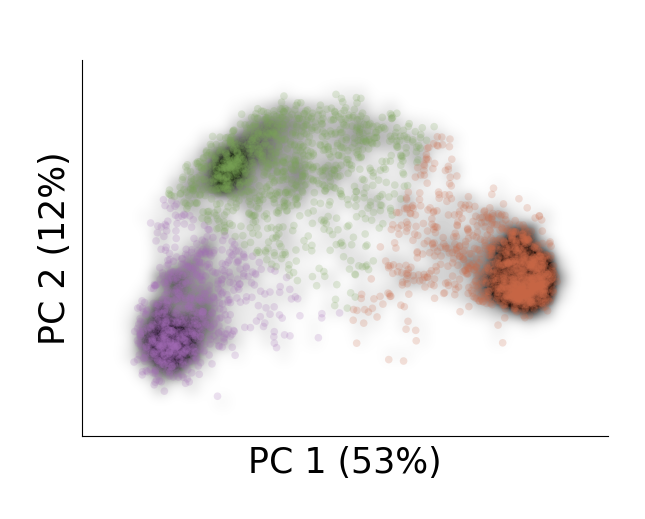

In [16]:
plt.figure(figsize=(7,7))
h, x, y, p = plt.hist2d(points_pca[:,0],points_pca[:,1],np.linspace(-50,50,50))
plt.clf()
plt.imshow(h.T,cmap="gray_r", interpolation = "gaussian",origin = "lower",vmax=30,extent=[-50,50,-50,50])
plt.scatter(points_pca[:,0],points_pca[:,1],c=cluster_labels,cmap=colors,alpha=.2,s=30,lw=0)
plt.yticks([])
plt.xticks([])
plt.xlim(-35,35)
plt.ylim(-25,25)
plt.ylabel("PC 2 (12%)",fontsize=25)
plt.xlabel("PC 1 (53%)",fontsize=25)
sns.despine()
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\3_f.png",dpi=800)

In [27]:
mean_clusters = []
n_clusters = []
for id_ in list(np.unique(cluster_labels)):
    if (np.sum(cluster_labels==id_)>1) and (id_!=-1):
        mean_clusters.append(remove_baseline(np.nanmean(full_[cluster_labels==id_,:],0)))
        n_clusters.append(np.sum(cluster_labels==id_))

In [28]:
mean_clusters = np.stack(mean_clusters,0)

In [29]:
traces_plot = full_.copy()
for i in range(traces_plot.shape[0]):
        traces_plot[i,:] = remove_baseline(traces_plot[i,:])

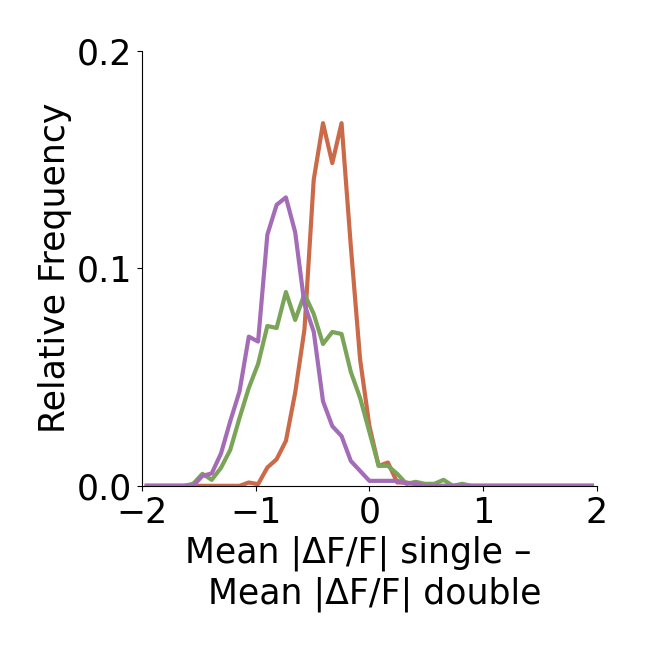

In [42]:
bins_ = np.linspace(-2,2,50)
bins_plot = (bins_[1:]+bins_[:-1])/2
labels = ["Cluster I","Cluster II","Cluster III"]
order = [0,2,1]
plt.figure()
for id_ in range(3):
    c,_ = np.histogram(np.nanmean(abs(traces_plot[cluster_labels==id_,100:400]),-1)-np.nanmean(abs(traces_plot[cluster_labels==id_,520:880]),-1),
                  bins_)
    c = c / np.sum(c)
    plt.plot(bins_plot,c,c=color_list[order[id_]],label=labels[order[id_]],lw=3)
plt.xlabel("Mean |ΔF/F| single –  \n Mean |ΔF/F| double",fontsize=25)
plt.ylabel("Relative Frequency",fontsize=25)
plt.xticks([-2,-1,0,1,2],fontsize=25)
plt.yticks([0,.1,.2],fontsize=25)
plt.ylim([0,.2])
plt.xlim([bins_[0],bins_[-1]])
sns.despine()
set_size(5,5)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\panels_afterreview\3_I_newnew.png",dpi=800)

In [84]:
napari_coords = full_coords.copy()
napari_coords[:,0] *= 9.6
napari_coords[:,1:] *= 0.6
v = napari.view_image(sf_AO)
v.add_points(napari_coords,n_dimensional=True)

<Points layer 'napari_coords' at 0x138e1fb3508>

In [ ]:
density_index = color_density(full_coords,th=20)
density_index_norm = np.interp(density_index,
                         np.array([np.min(density_index),30]),
                         [.1,1])

In [ ]:
jittered_z = full_coords[:,0].copy()*9.6 + np.random.uniform(low=-5, high=5, size=(full_coords.shape[0]))
jittered_z[jittered_z<=0] += 20

In [223]:
ms = 50
order = np.argsort(-cluster_labels)
cmap_ref = ListedColormap(cm.get_cmap('gray')(np.linspace(0,1,1000))[:500,:])
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(np.flip(y_proj,0),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
for i in range(full_coords.shape[0]):
    ax1.scatter(np.array([np.array(full_coords[order,-1][i])*0.6]),
                np.array([jittered_z[order][i]]),
                s=ms,c=np.array([cluster_labels[order][i]]),alpha=np.array([density_index_norm[order][i]]),
                cmap=colors,vmin=0,vmax=2,linewidths=0)
ax1.set_ylim([0,sf_AO.shape[0]])

ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(np.flip(z_proj,0),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
for i in range(full_coords.shape[0]):
    ax2.scatter(np.array([full_coords[order,2][i]*.6]),
                np.array([abs(full_coords[order,1][i]*.6-sf_AO.shape[1])]),
                s=ms,c=np.array([cluster_labels[order][i]]),alpha=np.array([density_index_norm[order][i]]),
                cmap=colors,vmin=0,vmax=2,linewidths=0)
ax2.set_ylim([0,sf_AO.shape[1]])
ax2.set_xlim([0,sf_AO.shape[2]])


ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1])
ax3.imshow(np.flip(np.rot90(x_proj,-1),0),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
for i in range(full_coords.shape[0]):
    ax3.scatter(np.array([abs(jittered_z[order][i]-sf_AO.shape[0])]),
                np.array([abs(full_coords[order,1][i]*.6-sf_AO.shape[1])]),
                s=ms,c=np.array([cluster_labels[order][i]]),alpha=np.array([density_index_norm[order][i]]),
                cmap=colors,vmin=0,vmax=2,linewidths=0)
ax3.set_xlim([sf_AO.shape[0],0])
ax3.set_ylim([0,sf_AO.shape[1]])
ax3.set_xticks([])
ax3.set_yticks([])
# plt.savefig(r"\\FUNES\Shared\Virginia\map_salt_clustering.pdf",dpi=800)
# plt.savefig(r"\\FUNES\Shared\Virginia\map_salt_clustering.png",dpi=800)

plt.show()

KeyboardInterrupt: 

In [12]:
ms = 50
order = np.argsort(-cluster_labels)
cmap_ref = ListedColormap(cm.get_cmap('gray')(np.linspace(0,1,1000))[:500,:])
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(np.flip(y_proj,0),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
for i in range(full_coords.shape[0]):
    ax1.scatter(np.array([np.array(full_coords[order,-1][i])*0.6]),
                np.array([jittered_z[order][i]]),
                s=ms,c="gold",alpha=np.array([density_index_norm[order][i]]),
                cmap=colors,vmin=0,vmax=2,linewidths=0)
ax1.set_ylim([0,sf_AO.shape[0]])

ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(np.flip(z_proj,0),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
for i in range(full_coords.shape[0]):
    ax2.scatter(np.array([full_coords[order,2][i]*.6]),
                np.array([abs(full_coords[order,1][i]*.6-sf_AO.shape[1])]),
                s=ms,c="gold",alpha=np.array([density_index_norm[order][i]]),
                cmap=colors,vmin=0,vmax=2,linewidths=0)
ax2.set_ylim([0,sf_AO.shape[1]])
ax2.set_xlim([0,sf_AO.shape[2]])


ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1])
ax3.imshow(np.flip(np.rot90(x_proj,-1),0),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
for i in range(full_coords.shape[0]):
    ax3.scatter(np.array([abs(jittered_z[order][i]-sf_AO.shape[0])]),
                np.array([abs(full_coords[order,1][i]*.6-sf_AO.shape[1])]),
                s=ms,c="gold",alpha=np.array([density_index_norm[order][i]]),
                cmap=colors,vmin=0,vmax=2,linewidths=0)
ax3.set_xlim([sf_AO.shape[0],0])
ax3.set_ylim([0,sf_AO.shape[1]])
ax3.set_xticks([])
ax3.set_yticks([])
# plt.savefig(r"\\FUNES\Shared\Virginia\map_salt_clustering.pdf",dpi=800)
# plt.savefig(r"\\FUNES\Shared\Virginia\map_salt_clustering.png",dpi=800)

plt.show()

NameError: name 'cluster_labels' is not defined

In [43]:
def remove_baseline(x_):
    return (x_ - np.nanmedian(x_[:109]))/np.std(x_)

In [44]:
traces_plot = full_.copy()
for i in range(traces_plot.shape[0]):
        traces_plot[i,:] = remove_baseline(traces_plot[i,:])

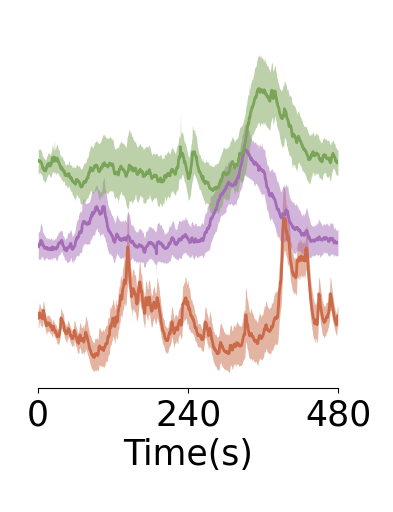

In [45]:
color_list = ["#cb6a49",
"#7aa457",
             "#a46cb7"]

f,ax = plt.subplots(1,1,figsize=(5,5))
off_ = 1
# ax.imshow(np.roll(array,-20, axis=1),aspect="auto",cmap="BrBG_r",alpha=.3, vmin=-0.03,vmax=0.03)
for n_clust in [0,2,1]:
    selected_traces = traces_plot[cluster_labels==n_clust,:] + off_
#     for n_trace in range(selected_traces.shape[0]):
#         ax.plot(selected_traces[n_trace],c=color_list[n_clust],alpha=.009,lw=.1)
    ax.fill_between(np.arange(960),
                    np.mean(selected_traces,0)-np.std(selected_traces,0),
                   np.mean(selected_traces,0)+np.std(selected_traces,0),lw=0,color=color_list[n_clust],alpha=.5)
    ax.plot(np.mean(selected_traces,0),c=color_list[n_clust],alpha=1,lw=2)
    off_+=2.5
# plt.plot(t_s,zscore(stimulus[1,:])-4,c="k",lw=2)
ax.set_yticks([])
ax.set_xticks([])
sns.despine(left=True,bottom=False)
ax.set_xlim([0,960])
ax.set_xticks([0,480,960])
ax.set_xticklabels([0,240,480])
# ax.set_ylim([-0,9])
ax.set_xlabel("Time(s)",fontsize=25)
plt.tight_layout()
set_size(3,3.5)
#plt.savefig(r"\\FUNES\Shared\Virginia\mean_clusters_temp.pdf",dpi=800)
# plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\3_g_new.png",dpi=800)
plt.show()

In [24]:
avgs = []
for n_clust in [0,2,1]:
    avg = zscore(np.concatenate([np.nanmean(traces_plot[cluster_labels==n_clust,:],0)]*5))
    avgs.append(avg)
avgs = np.stack(avgs)

In [29]:
fl.save(r"C:\Users\ge59xan\Desktop\sensory_regressors.h5",avgs)

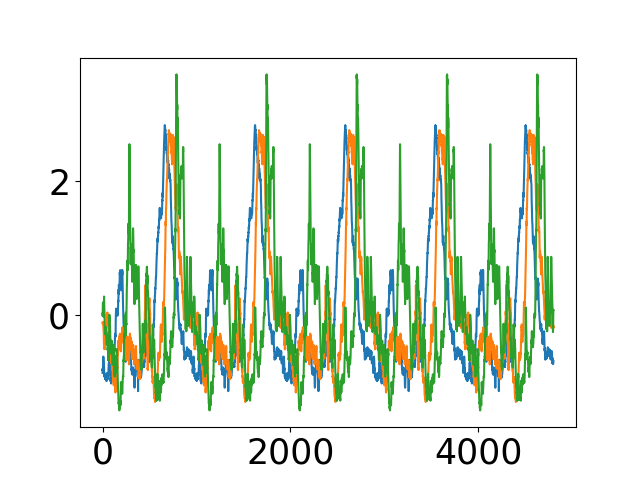

In [25]:
plt.figure()
plt.plot(avgs.T)
plt.show()

In [44]:
print(n_clusters, np.round(n_clusters / np.sum(n_clusters),2))

[1306, 878, 1088] [0.4  0.27 0.33]


In [46]:
intervals = [[111,192,392],[526,670,895]]

In [47]:
mean_activity = []
for i in range(cluster_labels.shape[0]):
    t = remove_baseline(full_[i,:])
    wctx_single = np.nanmean(t[intervals[0][0]:intervals[0][1]])
    ictx_single = np.nanmean(t[intervals[0][1]:intervals[0][2]])
    wctx_double = np.nanmean(t[intervals[1][0]:intervals[1][1]])
    ictx_double = np.nanmean(t[intervals[1][1]:intervals[1][2]])
    mean_activity.append(np.array([wctx_single,ictx_single,wctx_double,ictx_double]))
mean_activity = np.stack(mean_activity)

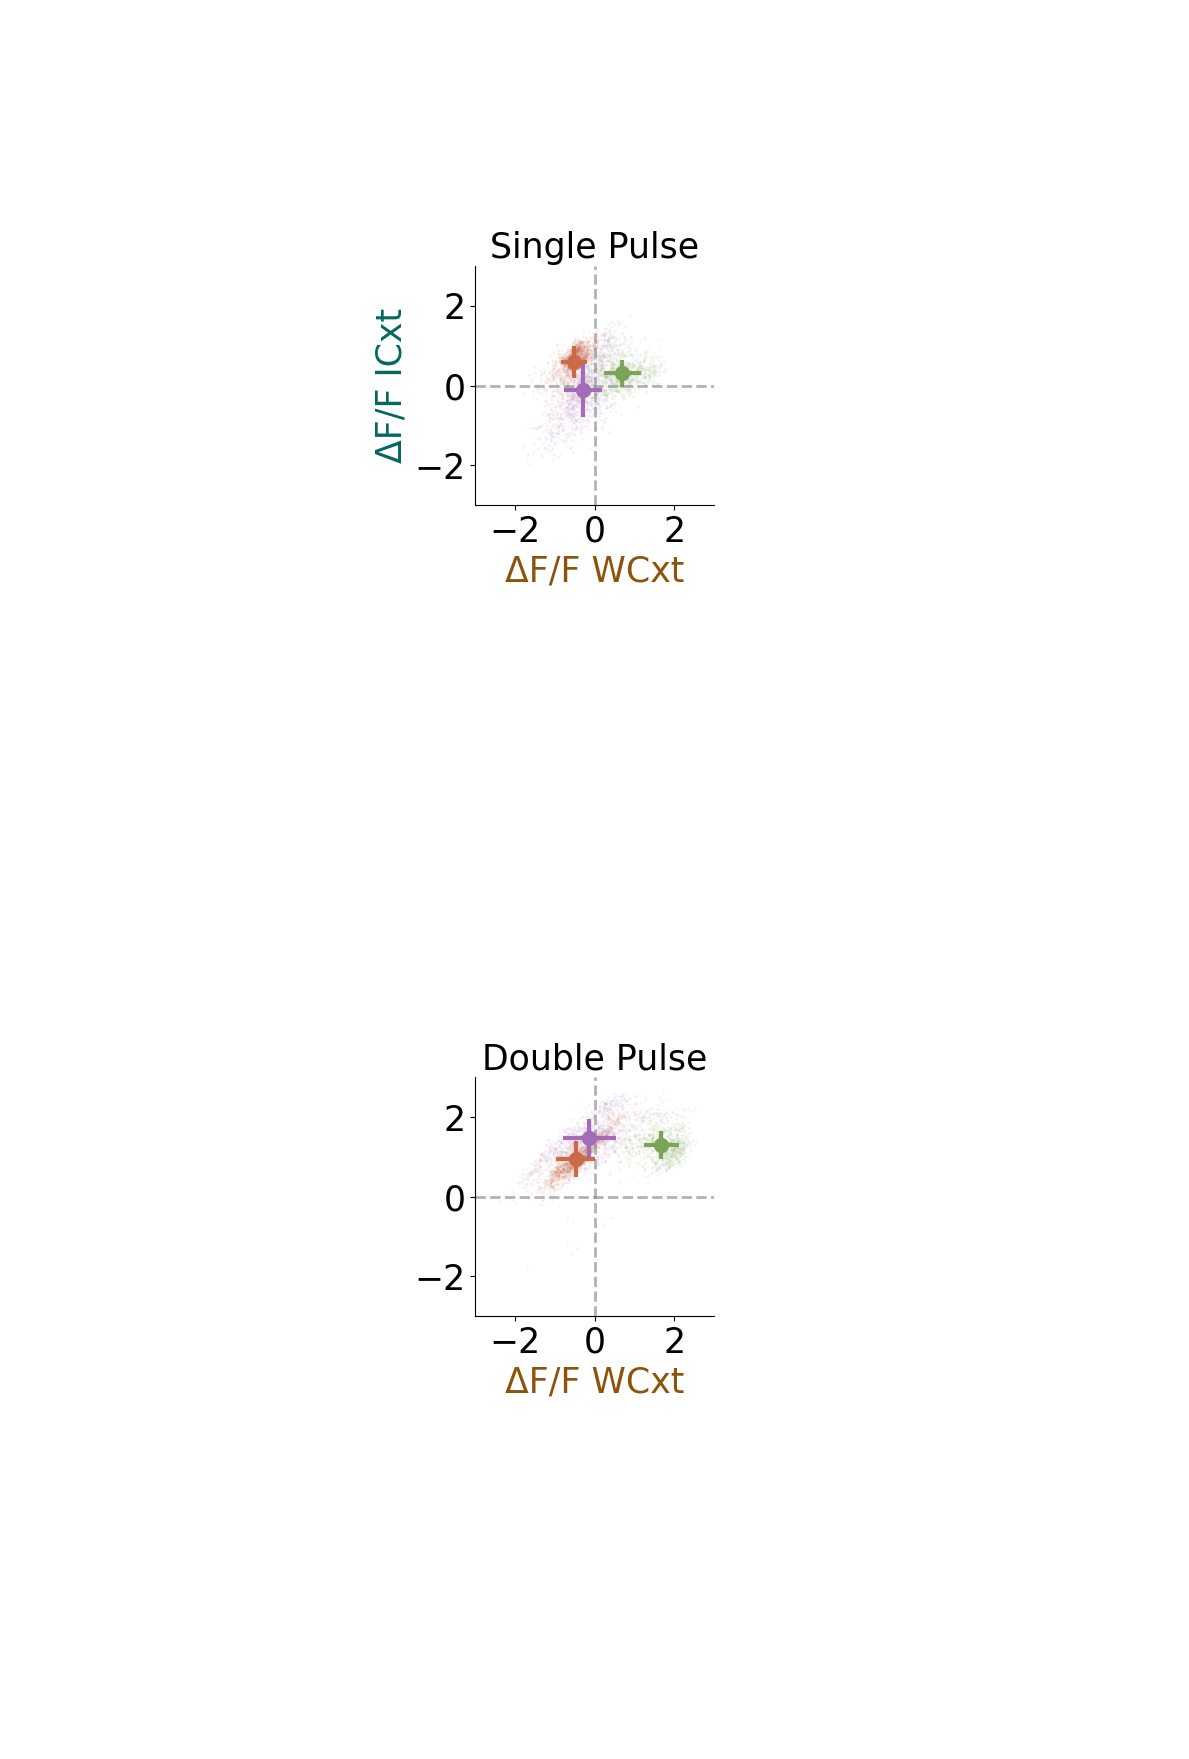

In [73]:
color_list = ["#cb6a49","#7aa457","#a46cb7"]
s = 3
asc = 0.1
f,a = plt.subplots(2,1)
a[0].scatter(mean_activity[cluster_labels==1,0], mean_activity[cluster_labels==1,1],
             c=color_list[2], s=s, alpha=asc, lw=0)
a[0].errorbar(np.nanmean(mean_activity[cluster_labels==1,0]),np.nanmean(mean_activity[cluster_labels==1,1]),
          xerr=np.std(mean_activity[cluster_labels==1,0]), yerr=np.std(mean_activity[cluster_labels==1,1]),
             color=color_list[2], lw=3, fmt="o", ms=10)
a[0].scatter(mean_activity[cluster_labels==2,0], mean_activity[cluster_labels==2,1],
             c=color_list[1], s=s, alpha=asc, lw=0)
a[0].errorbar(np.nanmean(mean_activity[cluster_labels==2,0]),np.nanmean(mean_activity[cluster_labels==2,1]),
          xerr=np.std(mean_activity[cluster_labels==2,0]), yerr=np.std(mean_activity[cluster_labels==2,1]),
             color=color_list[1], lw=3, fmt="o", ms=10)
a[0].scatter(mean_activity[cluster_labels==0,0], mean_activity[cluster_labels==0,1],
             c=color_list[0], s=s, alpha=asc, lw=0)
a[0].errorbar(np.nanmean(mean_activity[cluster_labels==0,0]),np.nanmean(mean_activity[cluster_labels==0,1]),
          xerr=np.std(mean_activity[cluster_labels==0,0]), yerr=np.std(mean_activity[cluster_labels==0,1]),
             color=color_list[0], lw=3, fmt="o", ms=10)
a[0].plot([-3,3],[0,0],"--",c="gray", lw=2,alpha=.6)
a[0].plot([0,0],[-3,3],"--",c="gray", lw=2,alpha=.6)

a[0].set_ylim([-3,3])
a[0].set_xlim([-3,3])
a[0].set_yticks([-2,0,2])
a[0].set_xticks([-2,0,2])
a[0].set_aspect(1)
a[0].set_ylabel("ΔF/F ICxt", fontsize=25, color="#036860")
a[0].set_xlabel("ΔF/F WCxt", fontsize=25, color="#8e530b")
a[0].set_title("Single Pulse", fontsize=25)

a[1].scatter(mean_activity[cluster_labels==1,2], mean_activity[cluster_labels==1,3],
             c=color_list[2], s=s, alpha=asc, lw=0)
a[1].errorbar(np.nanmean(mean_activity[cluster_labels==1,2]),np.nanmean(mean_activity[cluster_labels==1,3]),
          xerr=np.std(mean_activity[cluster_labels==1,2]), yerr=np.std(mean_activity[cluster_labels==1,3]),
             color=color_list[2], lw=3, fmt="o", ms=10)
a[1].errorbar(np.nanmean(mean_activity[cluster_labels==2,2]),np.nanmean(mean_activity[cluster_labels==2,3]),
          xerr=np.std(mean_activity[cluster_labels==2,2]), yerr=np.std(mean_activity[cluster_labels==2,3]),
             color=color_list[1], lw=3, fmt="o", ms=10)
a[1].errorbar(np.nanmean(mean_activity[cluster_labels==0,2]),np.nanmean(mean_activity[cluster_labels==0,3]),
          xerr=np.std(mean_activity[cluster_labels==0,2]), yerr=np.std(mean_activity[cluster_labels==0,3]),
             color=color_list[0], lw=3, fmt="o", ms=10)

a[1].scatter(mean_activity[cluster_labels==2,2], mean_activity[cluster_labels==2,3],
             c=color_list[1], s=s, alpha=asc, lw=0)
a[1].scatter(mean_activity[cluster_labels==0,2], mean_activity[cluster_labels==0,3],
             c=color_list[0], s=s, alpha=asc, lw=0)
a[1].plot([-3,3],[0,0],"--",c="gray", lw=2,alpha=.6)
a[1].plot([0,0],[-3,3],"--",c="gray", lw=2,alpha=.6)

a[1].set_ylim([-3,3])
a[1].set_xlim([-3,3])
a[1].set_yticks([-2,0,2])
a[1].set_xticks([-2,0,2])
a[1].set_aspect(1)
# a[1].set_ylabel("ΔF/F ICxt", fontsize=25, color="#036860")
a[1].set_xlabel("ΔF/F WCxt", fontsize=25, color="#8e530b")
a[1].set_title("Double Pulse", fontsize=25)
sns.despine()
plt.tight_layout()
set_size(10.5,10.5)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\panels_afterreview\3_I_II_newnew.png",dpi=800)

In [59]:
colorsIII = ListedColormap(["#FFFFFF","#cb6a49"])
colorsI = ListedColormap(["#FFFFFF","#a46cb7"])
colorsII = ListedColormap(["#FFFFFF","#7aa457"])

In [60]:
region_id = np.zeros((full_coords.shape[0],2))
for i_roi in range(full_coords.shape[0]):

    x = int(full_coords[i_roi,0])
    y = int(full_coords[i_roi,1])
    z = int(full_coords[i_roi,2])
    id_region = regions_ids[x,y,z]
    region_id[i_roi,:] = np.array([cluster_labels[i_roi],id_region])

In [61]:
target_regions = [[6,7,10],[9,13,14],[1,2],[17],[3,4,5],[19,20]]

In [62]:
plt.rcParams.update({'font.size': 25})

In [63]:
percentages = []
for reg_id in target_regions:

    counts = np.zeros(3)
    for single_region in reg_id:
        counts = counts + np.histogram(region_id[region_id[:,1]==single_region,0],np.array([-0.1,0.9,1.9,2.9]))[0]
    perc_ = counts / counts.sum()
    percentages.append(perc_)

In [64]:
percentages = np.stack(percentages)

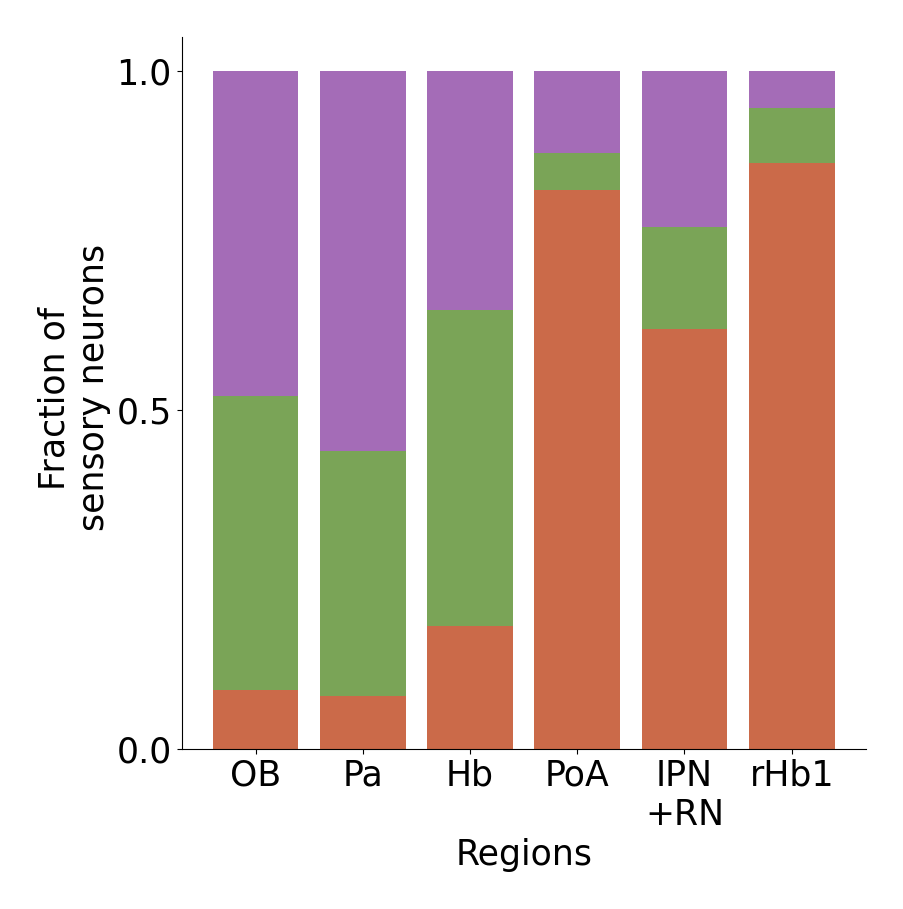

In [74]:
plt.figure()
plt.bar(np.arange(6),percentages[:,2]+percentages[:,1]+percentages[:,0],color=color_list[2],label="Type 3")
plt.bar(np.arange(6),percentages[:,2]+percentages[:,0],color=color_list[1],label="Type 2")
plt.bar(np.arange(6),percentages[:,0],color=color_list[0],label="Type 1")
plt.xticks(np.arange(6),["OB","Pa","Hb","PoA","IPN\n+RN","rHb1"],fontsize=25)
plt.yticks([0,.5,1],fontsize=25)
plt.ylabel("Fraction of \n sensory neurons",fontsize=25)
plt.xlabel("Regions",fontsize=25)
sns.despine()
set_size(7,7)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\3_l_newnewnew.png",dpi=800)

In [166]:
%%time
radius_rois = 20
volumes = []
for i_type in range(3):
    volume_ = np.zeros(sf_AO.shape)
    to_use = cluster_labels == i_type
    xy_to_use = full_coords[to_use,1:] * .6
    z_to_use = jittered_z[to_use]
    for i in range(xy_to_use.shape[0]):
        volume_+=create_bin_sphere(sf_AO.shape, (z_to_use[i],xy_to_use[i,0],
                                      xy_to_use[i,1]), radius_rois)
    volumes.append(volume_)
    print(i_type)

2
Wall time: 12min 30s


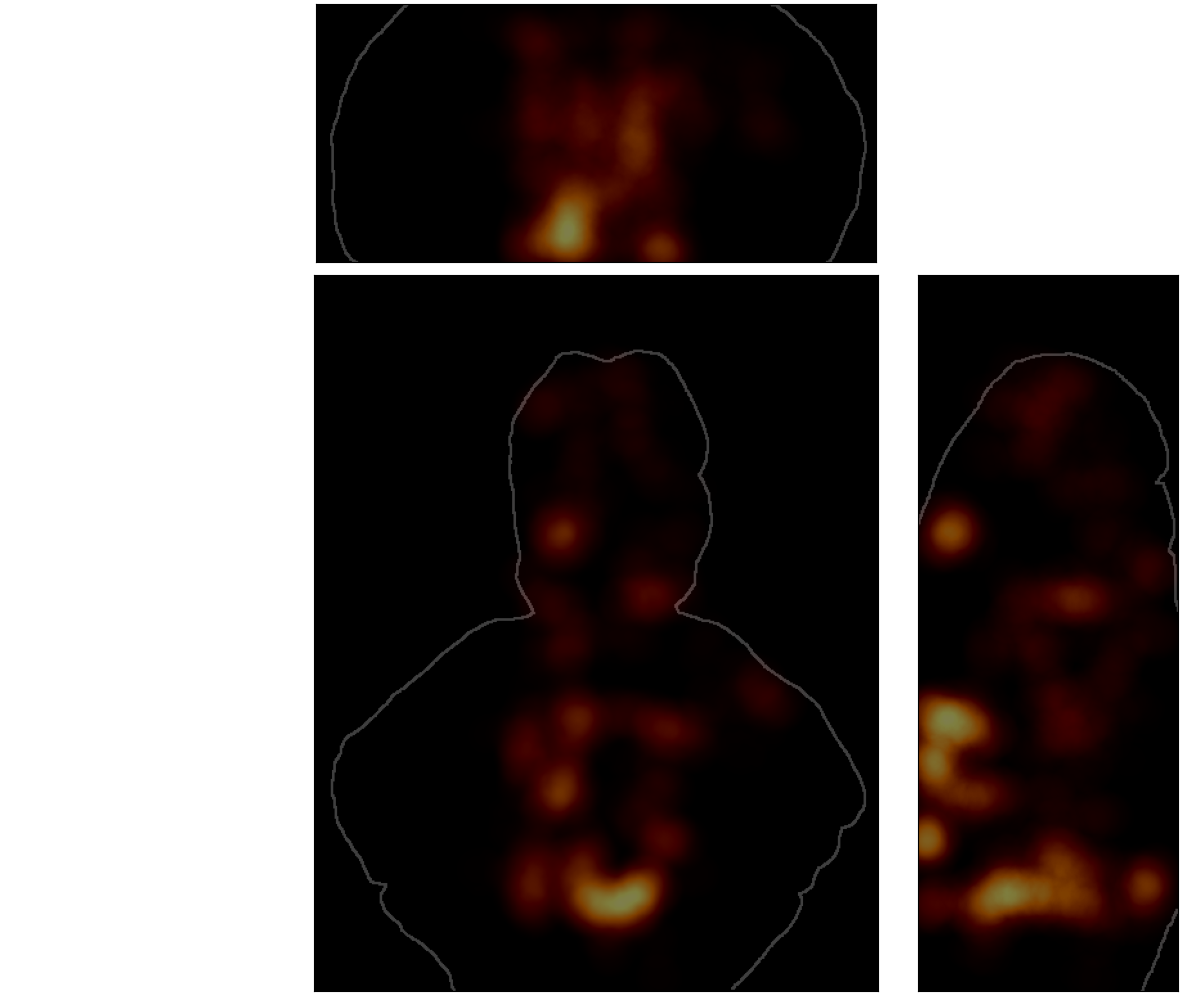

In [177]:
color_array = plt.cm.afmhot(np.linspace(0,1,1000))
color_array = ListedColormap(color_array[:800,:])
volume = volumes[1].copy()
vmin = None#(good_coords_display_pos.shape[0]*16)*.15
vmax=None
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1]) # make grid (can vary height AND width)
ax1 = fig.add_subplot(gs[0,1]) # specify where to plot
ax1.imshow(y_proj,
           interpolation=None,alpha=1,
           cmap=cmap_ref)
ax1.imshow(np.flip(volume.sum(1),0),cmap=color_array,alpha=.5,vmin=vmin, vmax=vmax)

ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1]) # specify where to plot

ax2.imshow(z_proj,
           interpolation=None,alpha=1,
           cmap=cmap_ref)
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap=color_array,alpha=.5,vmin=vmin, vmax=vmax)

ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1]) # specify where to plot

ax3.imshow(np.flip(np.rot90(x_proj,-1),1),
           interpolation=None,alpha=1,
           cmap=cmap_ref)
ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap=color_array,alpha=.5,vmin=vmin, vmax=vmax)

ax3.set_xticks([])
ax3.set_yticks([])

plt.show()